In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
print(tf.__version__)


2.3.1


In [22]:

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [23]:

import glob
import ntpath
import cv2


In [24]:

from sklearn.metrics.pairwise import cosine_similarity
import scipy as sc

Found [571] images


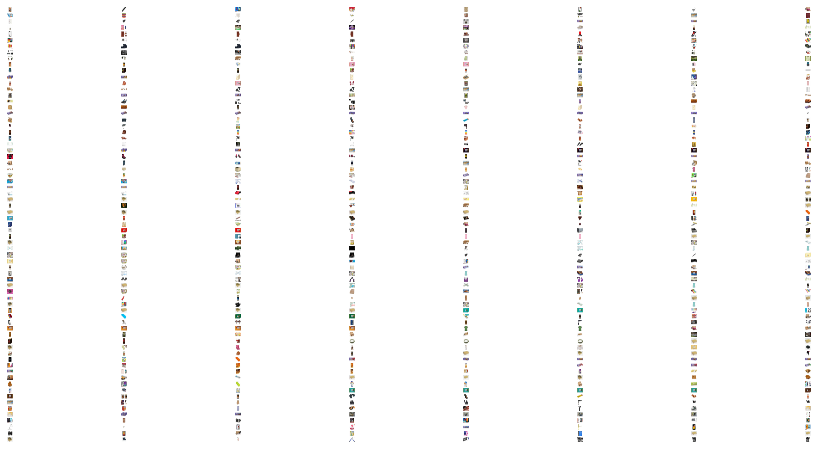

In [25]:

image_paths = glob.glob('FinalImages/*.jpg')
print(f'Found [{len(image_paths)}] images')

images = {}
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (200, 200))
    images[ntpath.basename(image_path)] = image      

n_col = 8
n_row = int(len(images)/n_col)
f, ax = plt.subplots(n_row, n_col, figsize=(16, 8))
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(list(images.values())[n_col*i + j])
        ax[i, j].set_axis_off()

In [26]:
def load_image(image):
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [400, 400])
  img = img[tf.newaxis, :] # shape -> (batch_size, h, w, d)
  return img

# content layers describe the image subject
content_layers = ['block5_conv2'] 

# style layers describe the image style
# we exclude the upper level layes to focus on small-size style details
style_layers = [ 
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        #'block4_conv1', 
        #'block5_conv1'
    ] 

def selected_layers_model(layer_names, baseline_model):
  outputs = [baseline_model.get_layer(name).output for name in layer_names]
  model = Model([vgg.input], outputs)
  return model

# style embedding is computed as concatenation of gram matrices of the style layers
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

class StyleModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleModel, self).__init__()
    self.vgg =  selected_layers_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # scale back the pixel values
    inputs = inputs*255.0
    # preprocess them with respect to VGG19 stats
    preprocessed_input = preprocess_input(inputs)
    # pass through the reduced network
    outputs = self.vgg(preprocessed_input)
    # segregate the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # calculate the gram matrix for each layer
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # assign the content representation and gram matrix in
    # a layer by layer fashion in dicts
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

def image_to_style(image_tensor):
    extractor = StyleModel(style_layers, content_layers)
    return extractor(image_tensor)['style']

def style_to_vec(style):
    # concatenate gram matrics in a flat vector
    return np.hstack([np.ravel(s) for s in style.values()]) 
    
# compute styles
image_style_embeddings = {}
for image_path in tqdm(image_paths): 
    image_tensor = load_image(image_path)
    style = style_to_vec( image_to_style(image_tensor) )
    image_style_embeddings[ntpath.basename(image_path)] = style


100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [24:12<00:00,  2.54s/it]


In [27]:
def search_by_style(reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    return sorted_neighbors[:11]
    
#     f, ax = plt.subplots(1, max_results, figsize=(16, 8))
#     for i, img in enumerate(sorted_neighbors[:max_results]):
#         ax[i].imshow(images[img[0]])
#         ax[i].set_axis_off()
    
#     plt.show()

In [28]:
search_by_style("57_0.jpg")

[('57_0.jpg', 0.0),
 ('57_1.jpg', 0.004510641098022461),
 ('39_1.jpg', 0.014744758605957031),
 ('39_0.jpg', 0.014814794063568115),
 ('451241_0.jpg', 0.016646265983581543),
 ('5299557_2.jpg', 0.02059704065322876),
 ('261890_1.jpg', 0.021300554275512695),
 ('261890_0.jpg', 0.02215290069580078),
 ('2450505_0.jpg', 0.02227485179901123),
 ('4985872_0.jpg', 0.022840261459350586),
 ('1692871_0.jpg', 0.023468077182769775)]

In [29]:
imagenames = [search_by_style(image_name) for image_name in images.keys()]

In [30]:
imagename = pd.DataFrame(imagenames)
imagename

,0,1,2,3,4,5,6,7,8,9,10
0,"(0_0.jpg, 0.0)","(34_0.jpg, 0.034230947494506836)","(83_0.jpg, 0.03853917121887207)","(1_0.jpg, 0.03901481628417969)","(38_0.jpg, 0.04167437553405762)","(1417301_0.jpg, 0.04272955656051636)","(44_0.jpg, 0.04671478271484375)","(15_0.jpg, 0.0477481484413147)","(5456115_0.jpg, 0.04823434352874756)","(90_0.jpg, 0.048406243324279785)","(3834622_0.jpg, 0.05086028575897217)"
1,"(101_0.jpg, 0.0)","(2719924_0.jpg, 0.017886221408843994)","(106_0.jpg, 0.02551037073135376)","(114_1.jpg, 0.025944948196411133)","(43_1.jpg, 0.025944948196411133)","(4985872_0.jpg, 0.029381871223449707)","(114_0.jpg, 0.03193169832229614)","(43_0.jpg, 0.03193169832229614)","(114_2.jpg, 0.038952529430389404)","(43_2.jpg, 0.038952529430389404)","(13_3.jpg, 0.04332393407821655)"
2,"(102_0.jpg, 0.0)","(77_0.jpg, 0.03231114149093628)","(89_0.jpg, 0.04031425714492798)","(52_0.jpg, 0.04492312669754028)","(124_0.jpg, 0.050794363021850586)","(16_0.jpg, 0.05146139860153198)","(3820267_0.jpg, 0.05487757921218872)","(60_0.jpg, 0.06163567304611206)","(6007737_0.jpg, 0.06444084644317627)","(6532298_0.jpg, 0.0719904899597168)","(6532298_1.jpg, 0.0719904899597168)"
3,"(1046233_0.jpg, 0.0)","(698940_1.jpg, 0.04172861576080322)","(698940_0.jpg, 0.04620552062988281)","(5749819_0.jpg, 0.0545501708984375)","(84_0.jpg, 0.05481654405593872)","(130374_0.jpg, 0.06225454807281494)","(66_0.jpg, 0.06485271453857422)","(2771913_0.jpg, 0.06694740056991577)","(2641262_0.jpg, 0.06911808252334595)","(5456115_0.jpg, 0.0709153413772583)","(17126_3.jpg, 0.07212746143341064)"
4,"(104_0.jpg, 0.0)","(766234_0.jpg, 0.04278784990310669)","(6298920_0.jpg, 0.04373437166213989)","(5939231_2.jpg, 0.04879838228225708)","(2_0.jpg, 0.04922986030578613)","(17_0.jpg, 0.05162858963012695)","(5939231_1.jpg, 0.05362743139266968)","(2219063_3.jpg, 0.05429232120513916)","(6438372_0.jpg, 0.05552375316619873)","(436356_0.jpg, 0.05569493770599365)","(217204_0.jpg, 0.055927276611328125)"
...,...,...,...,...,...,...,...,...,...,...,...
566,"(98_1.jpg, 0.0)","(98_2.jpg, 0.0022299885749816895)","(98_0.jpg, 0.022382795810699463)","(5962041_0.jpg, 0.034428954124450684)","(48_0.jpg, 0.035136640071868896)","(8_0.jpg, 0.03858214616775513)","(4_0.jpg, 0.03861290216445923)","(674194_0.jpg, 0.04146873950958252)","(20_0.jpg, 0.0443195104598999)","(34_0.jpg, 0.04508310556411743)","(105_0.jpg, 0.04596906900405884)"
567,"(98_2.jpg, 0.0)","(98_1.jpg, 0.0022299885749816895)","(98_0.jpg, 0.027008056640625)","(5962041_0.jpg, 0.028754770755767822)","(48_0.jpg, 0.03347140550613403)","(4_0.jpg, 0.03638350963592529)","(674194_0.jpg, 0.03809601068496704)","(8_0.jpg, 0.038179218769073486)","(105_0.jpg, 0.041637957096099854)","(34_0.jpg, 0.04197937250137329)","(5586792_0.jpg, 0.04294276237487793)"
568,"(98_3.jpg, 0.0)","(2719924_0.jpg, 0.04411429166793823)","(97_1.jpg, 0.056010663509368896)","(5305904_0.jpg, 0.05985748767852783)","(5023985_0.jpg, 0.06029409170150757)","(114_1.jpg, 0.06327849626541138)","(43_1.jpg, 0.06327849626541138)","(45_0.jpg, 0.06571000814437866)","(1238122_1.jpg, 0.06659120321273804)","(76_0.jpg, 0.0666993260383606)","(917036_0.jpg, 0.06704360246658325)"
569,"(99_0.jpg, 0.0)","(98_0.jpg, 0.03548818826675415)","(63_0.jpg, 0.04210507869720459)","(1_0.jpg, 0.04312163591384888)","(98_1.jpg, 0.047023236751556396)","(123_0.jpg, 0.04862457513809204)","(2271854_0.jpg, 0.05252707004547119)","(98_2.jpg, 0.053606629371643066)","(55_0.jpg, 0.05408352613449097)","(83_0.jpg, 0.055252134799957275)","(3243359_2.jpg, 0.05537283420562744)"


In [31]:
#Returns the first element of any list/tuple
def func(sorted_neighbour_tuple):
    return sorted_neighbour_tuple[0]

In [32]:
cosine = imagename.applymap(func)


In [33]:
cosine.to_csv("Method1.csv")